In [ ]:
!pip install lion_pytorch

## ModifiedVGGNet-16 : with EvoLved Sign Momentum (LION) or AGD for improving Image Classification Process

In [ ]:
import os
import pickle
from pathlib import Path
import tarfile

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
import torch.optim as optim
import torchvision
from torch.utils import data
from  torch.nn.init import orthogonal_
from torchvision import transforms
from PIL import Image
from lion_pytorch import Lion

#### Extract Cifar-10 Dataset

In [ ]:
def extract_dataset(archive_path, extract_path):
      tarfile.open(name=archive_path, mode='r:gz').extractall(extract_path)

In [ ]:
file_path = "./cifar-10-python.tar.gz"
extract_path = "./dataset/"

if not os.path.exists(extract_path):
      os.mkdir(extract_path)

if not os.path.isfile(file_path):
      !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

if not os.path.exists(extract_path + "cifar-10-batches-py/"):
      extract_dataset(file_path, extract_path)

--2023-06-28 13:47:53--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.9MB/s    in 5.7s    

2023-06-28 13:47:59 (28.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



#### Read dataset

In [ ]:
class CIFARSample:
      """
      One example from the CIFAR-10 dataset.
      """
      label_to_str = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
                    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
      def __init__(self, image, label, filename):
            self.image = image
            self.label = label
            self.filename = filename

      @property
      def label_hr(self):
            # Human readable label
            return self.label_to_str[self.label]
            # Mappings from numeric to human readable labels (and the other way around)

      def __str__(self):
            return f'[{self.label_hr}] - {self.filename}'

In [ ]:
def unpickle_data_batch(samples, batch_file, split):
        # Read pickle file
        with open(batch_file, 'rb') as f:
            data = pickle.load(f, encoding='bytes')

        # Handle the fact that train set is split into five batch files
        samples_start_idx = 0
        if split == 'train':
            batch_num = int(batch_file.name[-1])
            samples_start_idx = int(10000 * (batch_num - 1))

        # Each pickle batch file contains 10000 examples
        for i in range(10000):
            idx = samples_start_idx + i
            sample = CIFARSample(image=data[b'data'][i].reshape(3, 32, 32).transpose(1, 2, 0),
                                 label=data[b'labels'][i],
                                 filename=data[b'filenames'][i].decode())
            samples[split][idx] = sample

In [ ]:
samples = {
      'train': np.ndarray(shape=(50000,), dtype=CIFARSample),
      'test': np.ndarray(shape=(10000,), dtype=CIFARSample),
}

# Unpickle the five train batches
path_dataset = "./dataset/cifar-10-batches-py/"
dataset_root = Path(path_dataset)
for batch_f in dataset_root.glob('data_batch*'):
      unpickle_data_batch(samples, batch_f, split='train')

# Unpickle the only test batch
unpickle_data_batch(samples, dataset_root / 'test_batch', split='test')

#### Read dataset mean & std
it is important to have the data preprocessed with a zero mean. Therefore, as a first step, we will calculate the mean and standard deviation of the CIFAR dataset:

In [ ]:
train_data_samples = np.asarray([s.image for s in samples["train"]])
train_data = np.asarray([s for s in samples["train"]])
DATA_MEANS = (train_data_samples / 255.0).mean(axis=(0,1,2))
DATA_STD= (train_data_samples / 255.0).std(axis=(0,1,2))
print("data mean", DATA_MEANS)
print("data std", DATA_STD)


data mean [0.49139968 0.48215841 0.44653091]
data std [0.24703223 0.24348513 0.26158784]


#### Normalizing Train Data

We will use this information to define a transforms.Normalize module which will normalize our data accordingly. Additionally, we will use data augmentation during training. This reduces the risk of overfitting and helps CNNs to generalize better. Specifically, we will apply two random augmentations.

First, we will flip each image horizontally by a chance of 50% (transforms.RandomHorizontalFlip). The object class usually does not change when flipping an image, and we don’t expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called transforms.RandomResizedCrop. This transformation scales the image in a small range, while eventually changing the aspect ratio, and crops it afterward in the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same.

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.

In [ ]:
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(DATA_MEANS, DATA_STD)])
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ])
# test_transform = transforms.Compose(
#     [transforms.ToTensor()])

train_dataset = [[train_transform(Image.fromarray(i.image)), i.label]  for i in train_data]
test_dataset = [[test_transform(Image.fromarray(i.image)),i.label] for i in samples["test"]]

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

#### Check Normalize Data
To verify that our normalization works, we can print out the mean and standard deviation of the single batch. The mean should be close to 0 and the standard deviation close to 1 for each channel:

In [ ]:
imgs, _ = next(iter(train_loader))
print("Batch mean : ", imgs.mean(dim=[0, 2, 3]))
print("Batch std : ", imgs.std(dim=[0, 2, 3]))

Batch mean :  tensor([ 0.0230,  0.0094, -0.0110])
Batch std :  tensor([0.9613, 0.9662, 0.9665])


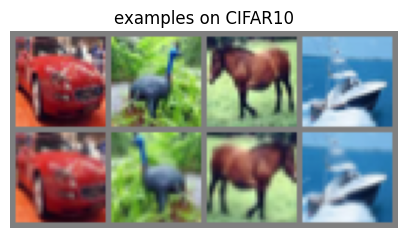

In [ ]:
NUM_IMAGES = 4
test_image_list = [Image.fromarray(train_data_samples[idx+5]) for idx in range(NUM_IMAGES)]
transform_images1 = [test_transform(img) for img in test_image_list]
train_image_list = [Image.fromarray(train_data_samples[idx+5]) for idx in range(NUM_IMAGES)]
transform_images2 = [train_transform(img) for img in train_image_list]

img_grid = torchvision.utils.make_grid(torch.stack(transform_images1 + transform_images2, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(5, 5))
plt.title("examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


#### Automatic Gradient Descent

In [ ]:
def singular_value(p):
    sv = np.sqrt(p.shape[0] / p.shape[1])
    if p.dim() == 4:
        sv /= np.sqrt(p.shape[2] * p.shape[3])
    return sv

class AGD(Optimizer):
    @torch.no_grad()
    def __init__(
            self,
            net,
            gain: float =1.0):

            assert (gain > 0)

            self.net = net
            self.depth = len(list(net.parameters()))
            self.gain = gain

            for p in net.parameters():
                  if p.dim() == 1: raise Exception("Biases are not supported.")
                  if p.dim() == 2: orthogonal_(p)
                  if p.dim() == 4:
                        for kx in range(p.shape[2]):
                              for ky in range(p.shape[3]):
                                    orthogonal_(p[:,:,kx,ky])
                  p *= singular_value(p)

    @torch.no_grad()
    def step(self):

            G = 0
            for p in self.net.parameters():
                  G += singular_value(p) * p.grad.norm(dim=(0,1)).sum()
            G /= self.depth

            log = torch.log(0.5 * (1 + torch.sqrt(1 + 4*G)))

            for p in self.net.parameters():
                  factor = singular_value(p) / p.grad.norm(dim=(0,1), keepdim=True)
                  p -= self.gain * log / self.depth * factor * p.grad

            return log

#### Try Swish Activation for FCNN Activation

In [ ]:
class Swish_func(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Swish_func.apply(input_tensor)

#### Main Neural Network

In [ ]:
def ModifiedVGG16(output_dim, use_swish): return VGG_CIFAR([64, 64, 'M',
                                                128, 128, 'M',
                                                256, 256, 256, 'M',
                                                512, 512, 512, 'M',
                                                512, 512, 512, 'M'],
                                                output_dim, use_swish=use_swish)

class VGG_CIFAR(nn.Module):
    def __init__(self, vgg_cfg, output_dim=10, bias=False, affine=False, use_swish: bool=True):
        super(VGG_CIFAR, self).__init__()
        self.bias = bias
        self.affine = affine
        self.use_swish = use_swish
        self.features = self._make_layers(vgg_cfg)
        # self.classifier = nn.Linear(512, output_dim, bias=self.bias)
        if(self.use_swish):
          self.classifier = nn.Sequential(nn.Linear(512, 256, bias=self.bias),
                                                                Swish(inplace=True),
                                                                nn.Dropout(0.35),
                                                                nn.Linear(256, output_dim, bias=self.bias))
        else:
          self.classifier = nn.Sequential(nn.Linear(512, 256, bias=self.bias),
                                                              nn.ReLU(inplace=True),
                                                              nn.Dropout(0.35),
                                                              nn.Linear(256, output_dim, bias=self.bias))
        self.act = nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return self.act(out)

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                ## Dropout layer after pooling
                layers += [nn.MaxPool2d(kernel_size=2, stride=2),
                           nn.Dropout(0.2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1, bias=self.bias),
                           nn.BatchNorm2d(x, affine=self.affine),
                           Swish(inplace=True) if self.use_swish else nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

#### Pytorch Training

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

#### Class Function for training and Eval

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

class MyModel:
    def __init__(self, n_classes, use_swish=True, loss_unit="crossentropy", optimizer_name=None):
        self.n_classes = n_classes
        self.model = self._create_model(n_classes, use_swish)
        self.loss_unit = loss_unit
        self.optimizer = self._create_optimizer(optimizer_name)
        if (use_swish):
            self.save_model_file = "Cifar_" + str(optimizer_name) + ".pth"
        else:
            self.save_model_file = "Cifar_" + str(optimizer_name) + "_WOSwish.pth"
        self.results = {'train_loss_list': [],
                        'test_loss_list': [],
                        'train_acc_list': [],
                        'test_acc_list': []}

    def _create_model(self, n_classes, use_swish):
        model = ModifiedVGG16(n_classes, use_swish)
        return to_device(model, device)

    def _create_optimizer(self, optimizer_name):
        optimizer = None
        if optimizer_name == "Adam":
            optimizer = torch.optim.AdamW(params=self.model.parameters(), lr=1e-04)
        elif optimizer_name == "Adam2":
            optimizer = torch.optim.AdamW(params=self.model.parameters(), lr=0.5e-04)
        elif optimizer_name == "Lion":
            optimizer = Lion(params=self.model.parameters(), lr=1e-5, weight_decay=1e-3)
        elif optimizer_name == "Lion2":
            optimizer = Lion(params=self.model.parameters(), lr=0.2e-4, weight_decay=1e-2)
        elif optimizer_name == "AGD":
            optimizer = AGD(net=self.model, gain=1.0)
        elif optimizer_name == "AGD2":
            optimizer = AGD(net=self.model, gain=0.85)
        else:
            raise Exception("Optimizer not defined")
        return optimizer

    def forward_and_backward_pass(self, dataloader, train):
        self.model.train() if train else self.model.eval()

        num_minibatches = len(dataloader)
        epoch_loss = 0
        epoch_acc = 0

        for data, target in tqdm(dataloader, total=num_minibatches):
            data, target = data, target
            output = self.model(data)

            if self.loss_unit == 'mse':
                onehot = torch.nn.functional.one_hot(target, num_classes=output.shape[1]).float()
                onehot *= np.sqrt(output.shape[1])
                loss = torch.nn.functional.mse_loss(output, onehot)
            if self.loss_unit == 'crossentropy':
                loss = torch.nn.functional.cross_entropy(output, target)

            if train:
                loss.backward()

            acc = (output.argmax(dim=1) == target).float().mean()

            if train:
                self.optimizer.step()
                self.model.zero_grad()

            epoch_acc += acc.item()
            epoch_loss += loss.item()

        return epoch_loss / num_minibatches, epoch_acc / num_minibatches

    def train(self, train_loader, test_loader, max_epoch):
        for epoch in range(max_epoch):
            print("\nEpoch", epoch)
            print("===================================" * 2)

            train_loss, train_acc = self.forward_and_backward_pass(train_loader, train=True)
            test_loss, test_acc = self.forward_and_backward_pass(test_loader, train=False)

            print("Train loss:\t", train_loss)
            print("Test loss: \t", test_loss)
            print("Train acc: \t", train_acc)
            print("Test acc:  \t", test_acc)

            self.results['train_loss_list'].append(train_loss)
            self.results['test_loss_list'].append(test_loss)
            self.results['train_acc_list'].append(train_acc)
            self.results['test_acc_list'].append(test_acc)

            torch.save(self.model.state_dict(), self.save_model_file)

#### Try using ModifiedVGG with Swish or without Swish

In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=True, loss_unit="crossentropy", optimizer_name="Lion2")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results6 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 74.89it/s]


Train loss:	 2.0805553772510628
Test loss: 	 2.002517979356307
Train acc: 	 0.3776041666666667
Test acc:  	 0.4544106012658228

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 76.13it/s]


Train loss:	 1.9353940104826903
Test loss: 	 1.9391143533247936
Train acc: 	 0.5214543269230769
Test acc:  	 0.5182950949367089

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 75.97it/s]


Train loss:	 1.8776385313425308
Test loss: 	 1.8960749499405487
Train acc: 	 0.5807091346153846
Test acc:  	 0.5609177215189873

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 75.35it/s]


Train loss:	 1.8474087409484081
Test loss: 	 1.8455120008203048
Train acc: 	 0.6116786858974359
Test acc:  	 0.6118473101265823

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 75.89it/s]


Train loss:	 1.8233904435084416
Test loss: 	 1.819362599638444
Train acc: 	 0.6350160256410257
Test acc:  	 0.6403283227848101

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 75.67it/s]


Train loss:	 1.8024745409305278
Test loss: 	 1.7869676804240746
Train acc: 	 0.6565104166666667
Test acc:  	 0.6722705696202531

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 74.91it/s]


Train loss:	 1.784099813302358
Test loss: 	 1.7739276297484772
Train acc: 	 0.6756810897435898
Test acc:  	 0.6856210443037974

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 73.51it/s]


Train loss:	 1.767771607178908
Test loss: 	 1.7822266756733762
Train acc: 	 0.6920072115384616
Test acc:  	 0.6785996835443038

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 74.78it/s]


Train loss:	 1.7547497880764498
Test loss: 	 1.7711201604408553
Train acc: 	 0.7052283653846154
Test acc:  	 0.6899723101265823

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 72.89it/s]


Train loss:	 1.7445860664049784
Test loss: 	 1.7445996184892292
Train acc: 	 0.7154046474358975
Test acc:  	 0.715684335443038

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 73.70it/s]


Train loss:	 1.7342494778144053
Test loss: 	 1.759147900569288
Train acc: 	 0.7258413461538461
Test acc:  	 0.7001582278481012

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 71.41it/s]


Train loss:	 1.7304769629087204
Test loss: 	 1.7488499034809162
Train acc: 	 0.7296274038461539
Test acc:  	 0.7106408227848101

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 71.22it/s]


Train loss:	 1.7154829080288228
Test loss: 	 1.7227601537221595
Train acc: 	 0.7445913461538461
Test acc:  	 0.7365506329113924

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 72.07it/s]


Train loss:	 1.7099215186559238
Test loss: 	 1.7282415055021454
Train acc: 	 0.7507411858974359
Test acc:  	 0.7319026898734177

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 71.16it/s]


Train loss:	 1.70695167749356
Test loss: 	 1.7069835994817033
Train acc: 	 0.7532051282051282
Test acc:  	 0.7529667721518988

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 73.45it/s]


Train loss:	 1.7048414808053236
Test loss: 	 1.7059870747071277
Train acc: 	 0.7552283653846154
Test acc:  	 0.7535601265822784

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 72.01it/s]


Train loss:	 1.6986368702008174
Test loss: 	 1.7231832878499092
Train acc: 	 0.7610777243589744
Test acc:  	 0.7361550632911392

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 74.59it/s]


Train loss:	 1.6916969693624055
Test loss: 	 1.70630536200125
Train acc: 	 0.7682491987179487
Test acc:  	 0.7534612341772152

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 73.50it/s]


Train loss:	 1.6844699608973968
Test loss: 	 1.7211869607997845
Train acc: 	 0.7760616987179487
Test acc:  	 0.7392207278481012

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 74.81it/s]


Train loss:	 1.6841420029982543
Test loss: 	 1.7152433606642712
Train acc: 	 0.7764022435897436
Test acc:  	 0.7448575949367089

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 73.90it/s]


Train loss:	 1.6772830553543874
Test loss: 	 1.6941988890684103
Train acc: 	 0.7825520833333334
Test acc:  	 0.7665150316455697

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 74.81it/s]


Train loss:	 1.6767306667107802
Test loss: 	 1.699550047705445
Train acc: 	 0.783213141025641
Test acc:  	 0.7619659810126582

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 75.78it/s]


Train loss:	 1.6701896068377373
Test loss: 	 1.6812145770350588
Train acc: 	 0.789823717948718
Test acc:  	 0.778184335443038

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 76.18it/s]


Train loss:	 1.6711978579178834
Test loss: 	 1.7061974247799645
Train acc: 	 0.7893429487179487
Test acc:  	 0.7542523734177216

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 76.31it/s]


Train loss:	 1.662313214632181
Test loss: 	 1.6744639028476764
Train acc: 	 0.798016826923077
Test acc:  	 0.7848101265822784

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 75.13it/s]


Train loss:	 1.6607852189968795
Test loss: 	 1.6898736395413363
Train acc: 	 0.7994991987179487
Test acc:  	 0.7712618670886076

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 75.05it/s]


Train loss:	 1.6598951324438438
Test loss: 	 1.678142007393173
Train acc: 	 0.8005608974358974
Test acc:  	 0.7822389240506329

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 74.28it/s]


Train loss:	 1.6538915288754
Test loss: 	 1.6732131423829477
Train acc: 	 0.8063301282051282
Test acc:  	 0.7882713607594937

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 75.69it/s]


Train loss:	 1.6548560393162264
Test loss: 	 1.6720631213127812
Train acc: 	 0.8056490384615385
Test acc:  	 0.7880735759493671

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 76.47it/s]


Train loss:	 1.6477082200539417
Test loss: 	 1.6844178408007078
Train acc: 	 0.8125400641025641
Test acc:  	 0.7757120253164557

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 75.31it/s]


Train loss:	 1.6481246153513591
Test loss: 	 1.6670401971551436
Train acc: 	 0.8119791666666667
Test acc:  	 0.7929193037974683

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 75.89it/s]


Train loss:	 1.63818619679182
Test loss: 	 1.664345080339456
Train acc: 	 0.8219751602564103
Test acc:  	 0.7948971518987342

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 75.15it/s]


Train loss:	 1.637251321780376
Test loss: 	 1.6690526310401628
Train acc: 	 0.8229767628205128
Test acc:  	 0.790743670886076

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 75.65it/s]


Train loss:	 1.6362134780639257
Test loss: 	 1.6581656872471677
Train acc: 	 0.8241185897435898
Test acc:  	 0.8025118670886076

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 74.82it/s]


Train loss:	 1.637869780185895
Test loss: 	 1.673476110530805
Train acc: 	 0.82265625
Test acc:  	 0.7857990506329114

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 74.32it/s]


Train loss:	 1.6377718723737276
Test loss: 	 1.6698796115344083
Train acc: 	 0.8228165064102564
Test acc:  	 0.7898536392405063

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 76.07it/s]


Train loss:	 1.6371249440388802
Test loss: 	 1.6633854349957238
Train acc: 	 0.8231971153846154
Test acc:  	 0.7967761075949367

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 75.12it/s]


Train loss:	 1.6299129800918775
Test loss: 	 1.6636646337147
Train acc: 	 0.8302884615384616
Test acc:  	 0.7959849683544303

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 75.21it/s]


Train loss:	 1.6298207915746248
Test loss: 	 1.6800944020476523
Train acc: 	 0.8307491987179487
Test acc:  	 0.779568829113924

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 74.49it/s]


Train loss:	 1.6297006995250016
Test loss: 	 1.647884042957161
Train acc: 	 0.8307892628205128
Test acc:  	 0.8127966772151899

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 75.26it/s]


Train loss:	 1.6236184101838331
Test loss: 	 1.6446456682832935
Train acc: 	 0.8367788461538461
Test acc:  	 0.8147745253164557

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 75.22it/s]


Train loss:	 1.6222665918179047
Test loss: 	 1.6587243955346602
Train acc: 	 0.8383613782051282
Test acc:  	 0.8019185126582279

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 73.88it/s]


Train loss:	 1.6253537095510042
Test loss: 	 1.6439608154417593
Train acc: 	 0.8350560897435897
Test acc:  	 0.8163568037974683

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 73.83it/s]


Train loss:	 1.6185962197108146
Test loss: 	 1.6360097006906438
Train acc: 	 0.8419871794871795
Test acc:  	 0.8241693037974683

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 72.23it/s]


Train loss:	 1.619699673163585
Test loss: 	 1.661075857621205
Train acc: 	 0.8408453525641025
Test acc:  	 0.7996439873417721

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 72.37it/s]


Train loss:	 1.6174488376348446
Test loss: 	 1.6621913638296006
Train acc: 	 0.8432091346153846
Test acc:  	 0.7981606012658228

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 72.55it/s]


Train loss:	 1.6137516678907933
Test loss: 	 1.6468452818786041
Train acc: 	 0.8467347756410256
Test acc:  	 0.8143789556962026

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 70.82it/s]


Train loss:	 1.6146589343364421
Test loss: 	 1.6534683538388601
Train acc: 	 0.8458733974358974
Test acc:  	 0.8069620253164557

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 70.13it/s]


Train loss:	 1.6140307197204002
Test loss: 	 1.6438710493377493
Train acc: 	 0.8463541666666666
Test acc:  	 0.8164556962025317

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 72.06it/s]


Train loss:	 1.6123832192176428
Test loss: 	 1.6508467061610161
Train acc: 	 0.8481570512820513
Test acc:  	 0.8098299050632911


In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=False, loss_unit="crossentropy", optimizer_name="Lion2")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results7 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 76.45it/s]


Train loss:	 2.113205655415853
Test loss: 	 2.0420373919643935
Train acc: 	 0.34126602564102565
Test acc:  	 0.41920490506329117

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 77.03it/s]


Train loss:	 1.95588096899864
Test loss: 	 1.938206577602821
Train acc: 	 0.5026842948717949
Test acc:  	 0.5185917721518988

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 78.42it/s] 


Train loss:	 1.8979419136658693
Test loss: 	 1.9183806407300732
Train acc: 	 0.5606770833333333
Test acc:  	 0.5390625

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 78.82it/s] 


Train loss:	 1.8653491848554367
Test loss: 	 1.8992387041260925
Train acc: 	 0.5935697115384615
Test acc:  	 0.5584454113924051

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 77.18it/s]


Train loss:	 1.8436424099482023
Test loss: 	 1.8369789063176023
Train acc: 	 0.6151241987179488
Test acc:  	 0.6215387658227848

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 78.06it/s] 


Train loss:	 1.817395877226805
Test loss: 	 1.8101820960829529
Train acc: 	 0.6419671474358974
Test acc:  	 0.6500197784810127

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 77.34it/s]


Train loss:	 1.7995265025358933
Test loss: 	 1.8094171738322777
Train acc: 	 0.6594551282051282
Test acc:  	 0.6497231012658228

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 73.43it/s]


Train loss:	 1.7891649371538407
Test loss: 	 1.8154863617088222
Train acc: 	 0.6697516025641026
Test acc:  	 0.6437895569620253

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 76.90it/s]


Train loss:	 1.7759864486180819
Test loss: 	 1.778266105470778
Train acc: 	 0.6840745192307692
Test acc:  	 0.6816653481012658

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 63.77it/s]


Train loss:	 1.7645251613396864
Test loss: 	 1.795098962663095
Train acc: 	 0.6955729166666667
Test acc:  	 0.6645569620253164

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 68.95it/s]


Train loss:	 1.7509181713446593
Test loss: 	 1.7719309948667694
Train acc: 	 0.7085136217948718
Test acc:  	 0.6877966772151899

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 70.46it/s]


Train loss:	 1.7448682904243469
Test loss: 	 1.7621135213707066
Train acc: 	 0.7148637820512821
Test acc:  	 0.696993670886076

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 78.02it/s]


Train loss:	 1.7366667557985356
Test loss: 	 1.748565236224404
Train acc: 	 0.7236177884615385
Test acc:  	 0.7123219936708861

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 70.85it/s]


Train loss:	 1.7273333344704065
Test loss: 	 1.7476696787001211
Train acc: 	 0.7322315705128205
Test acc:  	 0.7123219936708861

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 76.64it/s]


Train loss:	 1.7199287411494133
Test loss: 	 1.7501176520238948
Train acc: 	 0.7405248397435897
Test acc:  	 0.7093552215189873

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 65.00it/s]


Train loss:	 1.7138309246454484
Test loss: 	 1.7239814438397372
Train acc: 	 0.7461738782051283
Test acc:  	 0.7355617088607594

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 78.01it/s] 


Train loss:	 1.7130688126270588
Test loss: 	 1.727894226207009
Train acc: 	 0.7470953525641025
Test acc:  	 0.7321004746835443

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 72.41it/s]


Train loss:	 1.7061180860568315
Test loss: 	 1.7398356319982795
Train acc: 	 0.7536858974358974
Test acc:  	 0.7209256329113924

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 74.93it/s]


Train loss:	 1.703875444485591
Test loss: 	 1.740869532657575
Train acc: 	 0.7555288461538462
Test acc:  	 0.7189477848101266

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 69.03it/s]


Train loss:	 1.698398652749184
Test loss: 	 1.710912909688829
Train acc: 	 0.7616586538461538
Test acc:  	 0.7484177215189873

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 75.75it/s]


Train loss:	 1.6893118497652886
Test loss: 	 1.7131214488910724
Train acc: 	 0.7711338141025641
Test acc:  	 0.7459454113924051

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 75.64it/s]


Train loss:	 1.689722129014822
Test loss: 	 1.7050705106952522
Train acc: 	 0.7702724358974359
Test acc:  	 0.7544501582278481

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 74.97it/s]


Train loss:	 1.6821131687897903
Test loss: 	 1.703512131413327
Train acc: 	 0.7781650641025641
Test acc:  	 0.7566257911392406

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 69.54it/s]


Train loss:	 1.6771417938745938
Test loss: 	 1.7156873262381251
Train acc: 	 0.7830128205128205
Test acc:  	 0.7443631329113924

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 67.49it/s]


Train loss:	 1.6716810547388516
Test loss: 	 1.7094777550878404
Train acc: 	 0.7887620192307693
Test acc:  	 0.7504944620253164

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 76.61it/s]


Train loss:	 1.6736704111099243
Test loss: 	 1.7027210766756082
Train acc: 	 0.7865785256410256
Test acc:  	 0.7574169303797469

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 76.57it/s]


Train loss:	 1.667214057690058
Test loss: 	 1.6866354383999789
Train acc: 	 0.7929286858974359
Test acc:  	 0.7726463607594937

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 76.67it/s]


Train loss:	 1.660606111624302
Test loss: 	 1.7032338199736197
Train acc: 	 0.7997596153846154
Test acc:  	 0.7565268987341772

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 76.85it/s]


Train loss:	 1.6618988101298993
Test loss: 	 1.699610225761993
Train acc: 	 0.7984174679487179
Test acc:  	 0.7599881329113924

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 78.34it/s] 


Train loss:	 1.65953539732175
Test loss: 	 1.6800172238410274
Train acc: 	 0.8006410256410257
Test acc:  	 0.7804588607594937

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 76.85it/s]


Train loss:	 1.6603035584474222
Test loss: 	 1.6868343383451052
Train acc: 	 0.8002403846153846
Test acc:  	 0.7725474683544303

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 74.52it/s]


Train loss:	 1.659096677486713
Test loss: 	 1.6790497665163837
Train acc: 	 0.8009415064102564
Test acc:  	 0.7814477848101266

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 68.64it/s]


Train loss:	 1.6464436216232103
Test loss: 	 1.6872348800490173
Train acc: 	 0.814022435897436
Test acc:  	 0.7738330696202531

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 76.68it/s] 


Train loss:	 1.6519184751388354
Test loss: 	 1.6829822169074529
Train acc: 	 0.8087540064102564
Test acc:  	 0.7767998417721519

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 77.24it/s]


Train loss:	 1.6475143808584947
Test loss: 	 1.6837524311451972
Train acc: 	 0.8127203525641026
Test acc:  	 0.7766020569620253

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 72.21it/s]


Train loss:	 1.6470302942471626
Test loss: 	 1.7125463244281238
Train acc: 	 0.8135016025641025
Test acc:  	 0.746934335443038

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 75.09it/s]


Train loss:	 1.645406472682953
Test loss: 	 1.6746936779987962
Train acc: 	 0.8153445512820513
Test acc:  	 0.7854034810126582

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 77.17it/s]


Train loss:	 1.6412017305692037
Test loss: 	 1.6858750415753714
Train acc: 	 0.8193910256410256
Test acc:  	 0.7744264240506329

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 77.09it/s] 


Train loss:	 1.6391550660133363
Test loss: 	 1.6748883286608924
Train acc: 	 0.8213141025641025
Test acc:  	 0.7855023734177216

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 73.83it/s]


Train loss:	 1.638708449021364
Test loss: 	 1.6791599249537987
Train acc: 	 0.8211939102564103
Test acc:  	 0.7814477848101266

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 73.67it/s]


Train loss:	 1.6352240094771753
Test loss: 	 1.6809857449954069
Train acc: 	 0.8252203525641025
Test acc:  	 0.7792721518987342

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 78.26it/s]


Train loss:	 1.6352824146930989
Test loss: 	 1.6806155247024344
Train acc: 	 0.8252403846153846
Test acc:  	 0.7793710443037974

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 77.20it/s]


Train loss:	 1.6341204612683027
Test loss: 	 1.6717325660246838
Train acc: 	 0.826181891025641
Test acc:  	 0.7890625

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 77.68it/s]


Train loss:	 1.6307740859496287
Test loss: 	 1.6869487777540955
Train acc: 	 0.8295673076923077
Test acc:  	 0.7734375

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 78.19it/s] 


Train loss:	 1.6306630128469222
Test loss: 	 1.6670675368248662
Train acc: 	 0.8301883012820512
Test acc:  	 0.7940071202531646

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 77.22it/s]


Train loss:	 1.6297801522108224
Test loss: 	 1.6683629419230208
Train acc: 	 0.8309294871794872
Test acc:  	 0.7929193037974683

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 76.72it/s]


Train loss:	 1.627737388244042
Test loss: 	 1.6647638957711715
Train acc: 	 0.832832532051282
Test acc:  	 0.7958860759493671

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 74.51it/s]


Train loss:	 1.6225464215645424
Test loss: 	 1.6682143211364746
Train acc: 	 0.8379807692307693
Test acc:  	 0.7920292721518988

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 77.97it/s] 


Train loss:	 1.6233094643323849
Test loss: 	 1.651489798026749
Train acc: 	 0.837459935897436
Test acc:  	 0.8097310126582279

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 76.59it/s]


Train loss:	 1.6195912972474709
Test loss: 	 1.657570330402519
Train acc: 	 0.8410056089743589
Test acc:  	 0.8031052215189873


#### Try All Optimizer (Using Adam Optimizer First)

In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=True, loss_unit="crossentropy", optimizer_name="Adam")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results1 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 73.16it/s]


Train loss:	 2.0590275229551853
Test loss: 	 1.9950844834122476
Train acc: 	 0.397275641025641
Test acc:  	 0.4572784810126582

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 70.74it/s]


Train loss:	 1.923273945771731
Test loss: 	 1.9259787707389155
Train acc: 	 0.5354166666666667
Test acc:  	 0.5324367088607594

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 72.76it/s]


Train loss:	 1.867741158986703
Test loss: 	 1.8441979266420196
Train acc: 	 0.5907852564102564
Test acc:  	 0.6147151898734177

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 73.70it/s]


Train loss:	 1.8328964025546344
Test loss: 	 1.8258033975770203
Train acc: 	 0.6266426282051282
Test acc:  	 0.6326147151898734

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 71.10it/s]


Train loss:	 1.8041542444473657
Test loss: 	 1.8260975834689563
Train acc: 	 0.6549278846153846
Test acc:  	 0.6323180379746836

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 72.35it/s]


Train loss:	 1.7836343642992851
Test loss: 	 1.8025480388086053
Train acc: 	 0.6760416666666667
Test acc:  	 0.6574367088607594

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 69.31it/s]


Train loss:	 1.7660103244659229
Test loss: 	 1.8162489661687538
Train acc: 	 0.6924879807692308
Test acc:  	 0.6430973101265823

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 71.09it/s]


Train loss:	 1.753439456377274
Test loss: 	 1.7603483939472633
Train acc: 	 0.7065705128205129
Test acc:  	 0.6989715189873418

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 69.78it/s]


Train loss:	 1.7368363588284224
Test loss: 	 1.757579337192487
Train acc: 	 0.7230568910256411
Test acc:  	 0.7026305379746836

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 69.54it/s]


Train loss:	 1.7266273440458835
Test loss: 	 1.7476829064043262
Train acc: 	 0.7331530448717949
Test acc:  	 0.7129153481012658

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 70.12it/s]


Train loss:	 1.719132547500806
Test loss: 	 1.740087723430199
Train acc: 	 0.7409855769230769
Test acc:  	 0.7190466772151899

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 70.16it/s]


Train loss:	 1.712156911385365
Test loss: 	 1.723149672339234
Train acc: 	 0.747676282051282
Test acc:  	 0.7370450949367089

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 73.61it/s]


Train loss:	 1.7016203360679822
Test loss: 	 1.7223952148534074
Train acc: 	 0.7588141025641025
Test acc:  	 0.7369462025316456

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 71.98it/s]


Train loss:	 1.6989391192411765
Test loss: 	 1.7186566380005848
Train acc: 	 0.7614583333333333
Test acc:  	 0.7413963607594937

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 72.58it/s]


Train loss:	 1.689188315318181
Test loss: 	 1.6998603691028644
Train acc: 	 0.7709134615384615
Test acc:  	 0.7614715189873418

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 71.51it/s]


Train loss:	 1.6853616145940928
Test loss: 	 1.6995365136786351
Train acc: 	 0.7750801282051282
Test acc:  	 0.7603837025316456

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 72.91it/s]


Train loss:	 1.6815156273352794
Test loss: 	 1.698375481593458
Train acc: 	 0.778926282051282
Test acc:  	 0.7615704113924051

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 71.66it/s]


Train loss:	 1.673242753285628
Test loss: 	 1.7028959551944007
Train acc: 	 0.7868990384615384
Test acc:  	 0.7580102848101266

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 72.80it/s]


Train loss:	 1.6712632093674098
Test loss: 	 1.6997712141350856
Train acc: 	 0.7890424679487179
Test acc:  	 0.7600870253164557

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 73.68it/s]


Train loss:	 1.6673948740347837
Test loss: 	 1.6859053720401813
Train acc: 	 0.7932692307692307
Test acc:  	 0.7726463607594937

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 73.73it/s]


Train loss:	 1.6599908828735352
Test loss: 	 1.68608820438385
Train acc: 	 0.7998597756410256
Test acc:  	 0.7750197784810127

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 73.02it/s]


Train loss:	 1.6586691639362237
Test loss: 	 1.6895399335064465
Train acc: 	 0.8017227564102564
Test acc:  	 0.7707674050632911

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 75.41it/s]


Train loss:	 1.6515600366470142
Test loss: 	 1.7081029430220398
Train acc: 	 0.8092948717948718
Test acc:  	 0.7515822784810127

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 74.38it/s]


Train loss:	 1.6519584628251882
Test loss: 	 1.6672467928898485
Train acc: 	 0.8084334935897436
Test acc:  	 0.7930181962025317

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 75.29it/s]


Train loss:	 1.647787238084353
Test loss: 	 1.6907088560394095
Train acc: 	 0.8126001602564102
Test acc:  	 0.7691851265822784

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 74.33it/s]


Train loss:	 1.6463334966928531
Test loss: 	 1.6665839077551154
Train acc: 	 0.8139623397435898
Test acc:  	 0.7943037974683544

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 74.16it/s]


Train loss:	 1.6376165836285321
Test loss: 	 1.662529628488082
Train acc: 	 0.8233573717948718
Test acc:  	 0.7976661392405063

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 74.42it/s]


Train loss:	 1.6418868987988202
Test loss: 	 1.6788734740848783
Train acc: 	 0.8183894230769231
Test acc:  	 0.7814477848101266

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 74.53it/s]


Train loss:	 1.633271338083805
Test loss: 	 1.6683422191233575
Train acc: 	 0.82734375
Test acc:  	 0.7918314873417721

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 74.77it/s]


Train loss:	 1.628877071845226
Test loss: 	 1.673618816122224
Train acc: 	 0.8320713141025641
Test acc:  	 0.7869857594936709

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 74.73it/s]


Train loss:	 1.6276566343429761
Test loss: 	 1.6663699059546748
Train acc: 	 0.8326121794871795
Test acc:  	 0.7933148734177216

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 73.99it/s]


Train loss:	 1.629929581972269
Test loss: 	 1.6906407980979243
Train acc: 	 0.8304887820512821
Test acc:  	 0.7691851265822784

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 73.64it/s]


Train loss:	 1.6253164321948321
Test loss: 	 1.655018263225314
Train acc: 	 0.8355168269230769
Test acc:  	 0.8051819620253164

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 73.85it/s]


Train loss:	 1.6236027922385778
Test loss: 	 1.678051891206186
Train acc: 	 0.8371394230769231
Test acc:  	 0.7823378164556962

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 74.16it/s]


Train loss:	 1.619848532248766
Test loss: 	 1.6659780393672894
Train acc: 	 0.8404046474358975
Test acc:  	 0.7946004746835443

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 61.28it/s]


Train loss:	 1.6174305114990626
Test loss: 	 1.6669239801696585
Train acc: 	 0.8426883012820513
Test acc:  	 0.7936115506329114

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 73.03it/s]


Train loss:	 1.6116465223141205
Test loss: 	 1.651499456997159
Train acc: 	 0.8491987179487179
Test acc:  	 0.8093354430379747

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 73.37it/s]


Train loss:	 1.614247956031408
Test loss: 	 1.6626727128330665
Train acc: 	 0.8465945512820513
Test acc:  	 0.796182753164557

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 73.96it/s]


Train loss:	 1.6074114200396417
Test loss: 	 1.6662452220916748
Train acc: 	 0.8535657051282052
Test acc:  	 0.793809335443038

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 71.92it/s]


Train loss:	 1.6131166231937897
Test loss: 	 1.6658067733426638
Train acc: 	 0.8479967948717949
Test acc:  	 0.7942049050632911

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 74.76it/s]


Train loss:	 1.608509961458353
Test loss: 	 1.6561867375917072
Train acc: 	 0.8521634615384616
Test acc:  	 0.8032041139240507

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 74.77it/s]


Train loss:	 1.6058903162296
Test loss: 	 1.6475793802285497
Train acc: 	 0.8550681089743589
Test acc:  	 0.8125

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 73.42it/s]


Train loss:	 1.6035489042599995
Test loss: 	 1.6467271288738976
Train acc: 	 0.8572716346153846
Test acc:  	 0.8134889240506329

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 74.60it/s]


Train loss:	 1.6060406639025762
Test loss: 	 1.6566078361076644
Train acc: 	 0.8546274038461539
Test acc:  	 0.8036985759493671

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 73.72it/s]


Train loss:	 1.6051782757808
Test loss: 	 1.640393463871147
Train acc: 	 0.8551282051282051
Test acc:  	 0.8203125

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 73.53it/s]


Train loss:	 1.5981677165398231
Test loss: 	 1.6582768567000763
Train acc: 	 0.8623597756410256
Test acc:  	 0.8011273734177216

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 72.85it/s]


Train loss:	 1.5963476104614063
Test loss: 	 1.6386776785307293
Train acc: 	 0.8642628205128206
Test acc:  	 0.8212025316455697

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 74.44it/s]


Train loss:	 1.5946591954964857
Test loss: 	 1.6434925251369235
Train acc: 	 0.8662660256410256
Test acc:  	 0.8166534810126582

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 73.70it/s]


Train loss:	 1.5967901871754573
Test loss: 	 1.6412471668629707
Train acc: 	 0.8640224358974359
Test acc:  	 0.8191257911392406

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 73.20it/s]


Train loss:	 1.597234648007613
Test loss: 	 1.6470269296742692
Train acc: 	 0.8636217948717949
Test acc:  	 0.8140822784810127


In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=True, loss_unit="crossentropy", optimizer_name="Adam2")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results2 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 73.24it/s]


Train loss:	 2.0726347009340924
Test loss: 	 2.0367493614365784
Train acc: 	 0.38461538461538464
Test acc:  	 0.41871044303797467

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 73.40it/s]


Train loss:	 1.9148378763443386
Test loss: 	 1.9451693884934051
Train acc: 	 0.5464342948717948
Test acc:  	 0.510878164556962

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 73.55it/s]


Train loss:	 1.8566575371302092
Test loss: 	 1.8961306025710287
Train acc: 	 0.6035456730769231
Test acc:  	 0.5621044303797469

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 74.13it/s]


Train loss:	 1.817561445175073
Test loss: 	 1.835597816901871
Train acc: 	 0.6431490384615385
Test acc:  	 0.6221321202531646

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 74.42it/s]


Train loss:	 1.795445541235117
Test loss: 	 1.8540435335304164
Train acc: 	 0.6641826923076923
Test acc:  	 0.6058148734177216

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 73.93it/s]


Train loss:	 1.7696206795863616
Test loss: 	 1.7948337551913685
Train acc: 	 0.6907451923076923
Test acc:  	 0.6645569620253164

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 75.00it/s]


Train loss:	 1.7533647720630352
Test loss: 	 1.796693590622914
Train acc: 	 0.7071113782051283
Test acc:  	 0.6600079113924051

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 74.87it/s]


Train loss:	 1.7393616462365176
Test loss: 	 1.7619901518278485
Train acc: 	 0.7216546474358975
Test acc:  	 0.6991693037974683

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 74.18it/s]


Train loss:	 1.7278829828286781
Test loss: 	 1.7669468001474309
Train acc: 	 0.7323317307692307
Test acc:  	 0.6912579113924051

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 75.15it/s]


Train loss:	 1.7191623534911717
Test loss: 	 1.743877216230465
Train acc: 	 0.7417668269230769
Test acc:  	 0.7158821202531646

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 73.72it/s]


Train loss:	 1.7046102621616461
Test loss: 	 1.7320543648321418
Train acc: 	 0.7561498397435897
Test acc:  	 0.7271558544303798

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 73.15it/s]


Train loss:	 1.6995122001721308
Test loss: 	 1.7661605424518827
Train acc: 	 0.7612379807692308
Test acc:  	 0.694620253164557

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 72.47it/s]


Train loss:	 1.6874770259245848
Test loss: 	 1.7325708171989345
Train acc: 	 0.7737179487179487
Test acc:  	 0.7263647151898734

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 75.41it/s]


Train loss:	 1.6819306722054115
Test loss: 	 1.760315953930722
Train acc: 	 0.7783653846153846
Test acc:  	 0.6997626582278481

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 73.83it/s]


Train loss:	 1.6755305281052222
Test loss: 	 1.7330740614782405
Train acc: 	 0.7859975961538461
Test acc:  	 0.7250791139240507

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 74.14it/s]


Train loss:	 1.6670865645775428
Test loss: 	 1.717313678958748
Train acc: 	 0.7933894230769231
Test acc:  	 0.742879746835443

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 74.31it/s]


Train loss:	 1.6606179546087216
Test loss: 	 1.7175215573250493
Train acc: 	 0.8006810897435898
Test acc:  	 0.7424841772151899

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 72.24it/s]


Train loss:	 1.6572094342647454
Test loss: 	 1.7065447765060617
Train acc: 	 0.803886217948718
Test acc:  	 0.7534612341772152

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 72.74it/s]


Train loss:	 1.6487832943598428
Test loss: 	 1.6932345809815805
Train acc: 	 0.8124599358974359
Test acc:  	 0.766317246835443

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 69.42it/s]


Train loss:	 1.6449784615100957
Test loss: 	 1.6840982844557943
Train acc: 	 0.8160056089743589
Test acc:  	 0.7755142405063291

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 72.56it/s]


Train loss:	 1.6410787472358117
Test loss: 	 1.7115713101399095
Train acc: 	 0.8196113782051282
Test acc:  	 0.7486155063291139

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 70.32it/s]


Train loss:	 1.637107657469236
Test loss: 	 1.6842988276783424
Train acc: 	 0.8236778846153846
Test acc:  	 0.7755142405063291

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 72.22it/s]


Train loss:	 1.6319722606585576
Test loss: 	 1.683886884134027
Train acc: 	 0.8294070512820513
Test acc:  	 0.7763053797468354

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 72.17it/s]


Train loss:	 1.6302122883307628
Test loss: 	 1.6944135593462595
Train acc: 	 0.8310296474358975
Test acc:  	 0.7653283227848101

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 71.67it/s]


Train loss:	 1.621764463950426
Test loss: 	 1.6831965355933467
Train acc: 	 0.8396033653846153
Test acc:  	 0.7775909810126582

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 70.47it/s]


Train loss:	 1.6224911014238994
Test loss: 	 1.6766799039478544
Train acc: 	 0.8380608974358974
Test acc:  	 0.7830300632911392

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 70.90it/s]


Train loss:	 1.615506832416241
Test loss: 	 1.6790964030012299
Train acc: 	 0.8455128205128205
Test acc:  	 0.7811511075949367

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 69.35it/s]


Train loss:	 1.6124568606034304
Test loss: 	 1.6572302474251277
Train acc: 	 0.8484975961538461
Test acc:  	 0.8027096518987342

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 69.24it/s]


Train loss:	 1.608236468755282
Test loss: 	 1.6884338795384275
Train acc: 	 0.8528846153846154
Test acc:  	 0.7730419303797469

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 69.40it/s]


Train loss:	 1.6064891763222524
Test loss: 	 1.6744455053836484
Train acc: 	 0.854326923076923
Test acc:  	 0.7857990506329114

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 69.98it/s]


Train loss:	 1.6056106983087002
Test loss: 	 1.6851368720018411
Train acc: 	 0.8552483974358974
Test acc:  	 0.7743275316455697

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 70.20it/s]


Train loss:	 1.599992301219549
Test loss: 	 1.6640903421595126
Train acc: 	 0.8613581730769231
Test acc:  	 0.7956882911392406

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 69.96it/s]


Train loss:	 1.5951824952394535
Test loss: 	 1.6608959406237058
Train acc: 	 0.8655649038461538
Test acc:  	 0.7990506329113924

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 71.85it/s]


Train loss:	 1.595171101582356
Test loss: 	 1.674685534042648
Train acc: 	 0.865665064102564
Test acc:  	 0.785996835443038

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 65.28it/s]


Train loss:	 1.590978221098582
Test loss: 	 1.6528740698778177
Train acc: 	 0.8704927884615384
Test acc:  	 0.806368670886076

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 70.62it/s]


Train loss:	 1.5909055129075662
Test loss: 	 1.6559771480439585
Train acc: 	 0.8704126602564103
Test acc:  	 0.8047863924050633

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 72.04it/s]


Train loss:	 1.5859329972511682
Test loss: 	 1.6713602497607847
Train acc: 	 0.8753205128205128
Test acc:  	 0.7886669303797469

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 72.16it/s]


Train loss:	 1.5848450666818863
Test loss: 	 1.6621789238120936
Train acc: 	 0.8761017628205128
Test acc:  	 0.7983583860759493

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 72.39it/s]


Train loss:	 1.5815581236130152
Test loss: 	 1.6602685149711898
Train acc: 	 0.8790464743589743
Test acc:  	 0.7988528481012658

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 71.12it/s]


Train loss:	 1.5829646908319914
Test loss: 	 1.6627536740484117
Train acc: 	 0.8779447115384615
Test acc:  	 0.7970727848101266

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 73.03it/s]


Train loss:	 1.5761469455865713
Test loss: 	 1.6712753893453864
Train acc: 	 0.885136217948718
Test acc:  	 0.7877768987341772

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 72.81it/s]


Train loss:	 1.5781083984252735
Test loss: 	 1.6602901250501223
Train acc: 	 0.8830929487179487
Test acc:  	 0.8008306962025317

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 70.94it/s]


Train loss:	 1.5779938706984886
Test loss: 	 1.6634300751022146
Train acc: 	 0.8828325320512821
Test acc:  	 0.797567246835443

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 71.09it/s]


Train loss:	 1.5743571339509426
Test loss: 	 1.6513248516034476
Train acc: 	 0.88671875
Test acc:  	 0.8084454113924051

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 72.83it/s]


Train loss:	 1.5720862315251276
Test loss: 	 1.657070037684863
Train acc: 	 0.8887019230769231
Test acc:  	 0.8034018987341772

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 72.90it/s]


Train loss:	 1.5712312206243857
Test loss: 	 1.6477695190453832
Train acc: 	 0.8895232371794872
Test acc:  	 0.8120055379746836

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 73.75it/s]


Train loss:	 1.5677516261736553
Test loss: 	 1.654635865477067
Train acc: 	 0.893008814102564
Test acc:  	 0.805379746835443

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 74.33it/s]


Train loss:	 1.566301610836616
Test loss: 	 1.643744845933552
Train acc: 	 0.8950320512820513
Test acc:  	 0.8169501582278481

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 74.06it/s]


Train loss:	 1.5615284024140774
Test loss: 	 1.643629270263865
Train acc: 	 0.899579326923077
Test acc:  	 0.8173457278481012

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 72.17it/s]


Train loss:	 1.5617106397946676
Test loss: 	 1.644700933106338
Train acc: 	 0.8997596153846154
Test acc:  	 0.814181170886076


#### Using AGD (Automatic-Gradient Descent) Optimizer

In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=True, loss_unit="crossentropy", optimizer_name="AGD")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results3 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 69.81it/s]


Train loss:	 2.275323661779746
Test loss: 	 2.2863773907287213
Train acc: 	 0.16654647435897435
Test acc:  	 0.1415150316455696

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 73.47it/s]


Train loss:	 2.19425044915615
Test loss: 	 2.2418277414539194
Train acc: 	 0.24549278846153846
Test acc:  	 0.21143196202531644

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 75.05it/s]


Train loss:	 2.0867303747397203
Test loss: 	 2.1154747673227816
Train acc: 	 0.3685697115384615
Test acc:  	 0.338310917721519

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 71.51it/s]


Train loss:	 1.987215455678793
Test loss: 	 2.06958920744401
Train acc: 	 0.47682291666666665
Test acc:  	 0.38666930379746833

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 72.82it/s]


Train loss:	 1.9235431787295219
Test loss: 	 1.933827142172222
Train acc: 	 0.5372796474358974
Test acc:  	 0.5249208860759493

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 70.74it/s]


Train loss:	 1.8893021103663323
Test loss: 	 1.925711729858495
Train acc: 	 0.5717948717948718
Test acc:  	 0.5318433544303798

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 70.72it/s]


Train loss:	 1.864386919217232
Test loss: 	 1.8802889766572397
Train acc: 	 0.5959935897435897
Test acc:  	 0.5782238924050633

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 70.43it/s]


Train loss:	 1.8405154350476387
Test loss: 	 1.913301170626773
Train acc: 	 0.618709935897436
Test acc:  	 0.5442049050632911

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 72.18it/s]


Train loss:	 1.8120340494009164
Test loss: 	 1.806957401806795
Train acc: 	 0.6495993589743589
Test acc:  	 0.653184335443038

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 73.44it/s]


Train loss:	 1.7873723403001442
Test loss: 	 1.844176159629339
Train acc: 	 0.6743990384615385
Test acc:  	 0.6157041139240507

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 74.06it/s]


Train loss:	 1.7673760560842662
Test loss: 	 1.7915012776097166
Train acc: 	 0.6939503205128205
Test acc:  	 0.6670292721518988

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 73.19it/s]


Train loss:	 1.7526378374833327
Test loss: 	 1.7820545133156112
Train acc: 	 0.7083733974358974
Test acc:  	 0.6758306962025317

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 73.93it/s]


Train loss:	 1.7386798748603234
Test loss: 	 1.7691687315325193
Train acc: 	 0.7228565705128205
Test acc:  	 0.6893789556962026

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 75.20it/s]


Train loss:	 1.729209309357863
Test loss: 	 1.7612296101413196
Train acc: 	 0.7317708333333334
Test acc:  	 0.6995648734177216

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 73.19it/s]


Train loss:	 1.7149684025691105
Test loss: 	 1.7712538876110995
Train acc: 	 0.7461338141025641
Test acc:  	 0.6875

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 74.24it/s]


Train loss:	 1.7064548626924172
Test loss: 	 1.7412314580965647
Train acc: 	 0.7548878205128206
Test acc:  	 0.7172666139240507

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 74.27it/s]


Train loss:	 1.6990914424260457
Test loss: 	 1.7467998402028144
Train acc: 	 0.7622596153846154
Test acc:  	 0.712618670886076

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 74.05it/s]


Train loss:	 1.6918922708584712
Test loss: 	 1.7591132921508597
Train acc: 	 0.7699719551282052
Test acc:  	 0.7008504746835443

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 75.14it/s]


Train loss:	 1.6873138378827999
Test loss: 	 1.7496056783048413
Train acc: 	 0.7732371794871795
Test acc:  	 0.7091574367088608

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 73.32it/s]


Train loss:	 1.6782616710051512
Test loss: 	 1.7111474517025524
Train acc: 	 0.7833133012820512
Test acc:  	 0.7474287974683544

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 73.43it/s]


Train loss:	 1.6721702184432592
Test loss: 	 1.711966258061083
Train acc: 	 0.7889823717948717
Test acc:  	 0.7477254746835443

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 72.02it/s]


Train loss:	 1.6671861789165399
Test loss: 	 1.7225382192225396
Train acc: 	 0.7938701923076923
Test acc:  	 0.7382318037974683

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 70.47it/s]


Train loss:	 1.6614482632050147
Test loss: 	 1.6855126800416391
Train acc: 	 0.799639423076923
Test acc:  	 0.7737341772151899

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 70.65it/s]


Train loss:	 1.6566590226613558
Test loss: 	 1.7157669022113462
Train acc: 	 0.8040064102564103
Test acc:  	 0.7448575949367089

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 72.37it/s]


Train loss:	 1.6514824249805549
Test loss: 	 1.6828258369542375
Train acc: 	 0.8092948717948718
Test acc:  	 0.7763053797468354

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 74.70it/s]


Train loss:	 1.6469605448918465
Test loss: 	 1.6985050273846976
Train acc: 	 0.8142027243589743
Test acc:  	 0.7609770569620253

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 73.45it/s]


Train loss:	 1.641274161522205
Test loss: 	 1.6891220279886752
Train acc: 	 0.8198116987179487
Test acc:  	 0.7716574367088608

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 71.22it/s]


Train loss:	 1.636733867877569
Test loss: 	 1.6749524828753894
Train acc: 	 0.8244391025641026
Test acc:  	 0.7854034810126582

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 71.59it/s]


Train loss:	 1.6356029913975643
Test loss: 	 1.6957662663882291
Train acc: 	 0.8255408653846154
Test acc:  	 0.7644382911392406

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 70.39it/s]


Train loss:	 1.6321080152805034
Test loss: 	 1.680279764948012
Train acc: 	 0.8287860576923077
Test acc:  	 0.7793710443037974

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 70.39it/s]


Train loss:	 1.6255449753541213
Test loss: 	 1.6948276350769815
Train acc: 	 0.8357371794871795
Test acc:  	 0.7648338607594937

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 71.43it/s]


Train loss:	 1.623053447711162
Test loss: 	 1.6944787396660335
Train acc: 	 0.8381810897435897
Test acc:  	 0.765625

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 73.21it/s]


Train loss:	 1.6230680661323742
Test loss: 	 1.663332172586948
Train acc: 	 0.8375801282051282
Test acc:  	 0.7967761075949367

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 74.43it/s]


Train loss:	 1.6186301607352036
Test loss: 	 1.670337403876872
Train acc: 	 0.8423076923076923
Test acc:  	 0.790743670886076

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 73.48it/s]


Train loss:	 1.615990169843038
Test loss: 	 1.6867872929271264
Train acc: 	 0.8446314102564103
Test acc:  	 0.7735363924050633

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 73.33it/s]


Train loss:	 1.610835381043263
Test loss: 	 1.6748576843285863
Train acc: 	 0.8505408653846154
Test acc:  	 0.7852056962025317

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 74.40it/s]


Train loss:	 1.6085641781489055
Test loss: 	 1.6649040783507913
Train acc: 	 0.8522636217948718
Test acc:  	 0.7946004746835443

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 73.98it/s]


Train loss:	 1.6058619866004358
Test loss: 	 1.6636102003387259
Train acc: 	 0.8549479166666667
Test acc:  	 0.7966772151898734

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 73.90it/s]


Train loss:	 1.6021473484161572
Test loss: 	 1.6787845877152454
Train acc: 	 0.8589142628205129
Test acc:  	 0.7809533227848101

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 73.43it/s]


Train loss:	 1.600300227678739
Test loss: 	 1.673186862016026
Train acc: 	 0.8609975961538462
Test acc:  	 0.7857990506329114

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 72.55it/s]


Train loss:	 1.5988228804025895
Test loss: 	 1.671329071250143
Train acc: 	 0.8623197115384615
Test acc:  	 0.7879746835443038

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 75.99it/s]


Train loss:	 1.5957382232714923
Test loss: 	 1.6507979691783083
Train acc: 	 0.8657051282051282
Test acc:  	 0.8096321202531646

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 73.00it/s]


Train loss:	 1.5935940247315628
Test loss: 	 1.649979176400583
Train acc: 	 0.8674479166666667
Test acc:  	 0.8097310126582279

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 73.93it/s]


Train loss:	 1.5887519341248733
Test loss: 	 1.6632307601880423
Train acc: 	 0.8723958333333334
Test acc:  	 0.796182753164557

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 73.64it/s]


Train loss:	 1.5870920991286253
Test loss: 	 1.646490475799464
Train acc: 	 0.8737780448717949
Test acc:  	 0.8140822784810127

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 73.22it/s]


Train loss:	 1.5855279794106116
Test loss: 	 1.680423812021183
Train acc: 	 0.8759214743589744
Test acc:  	 0.7796677215189873

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 74.68it/s]


Train loss:	 1.5834937716141726
Test loss: 	 1.6557976098000249
Train acc: 	 0.8772836538461538
Test acc:  	 0.8038963607594937

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 72.61it/s]


Train loss:	 1.5803123312118725
Test loss: 	 1.6411205122742472
Train acc: 	 0.8806290064102564
Test acc:  	 0.8201147151898734

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 72.17it/s]


Train loss:	 1.5788763214380312
Test loss: 	 1.6628643002691148
Train acc: 	 0.8825120192307693
Test acc:  	 0.7977650316455697

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 70.54it/s]


Train loss:	 1.5771556615829467
Test loss: 	 1.6553283130066305
Train acc: 	 0.8838741987179487
Test acc:  	 0.8044897151898734


In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=True, loss_unit="crossentropy", optimizer_name="AGD2")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results4 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 72.67it/s]


Train loss:	 2.2771392999551234
Test loss: 	 2.2729866474489624
Train acc: 	 0.17552083333333332
Test acc:  	 0.21835443037974683

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 72.38it/s]


Train loss:	 2.1955679856813872
Test loss: 	 2.238209341145769
Train acc: 	 0.25158253205128206
Test acc:  	 0.19630142405063292

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 72.65it/s]


Train loss:	 2.1246199008746025
Test loss: 	 2.2472774559938453
Train acc: 	 0.3182491987179487
Test acc:  	 0.1964992088607595

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 72.98it/s]


Train loss:	 2.0427230232801192
Test loss: 	 2.116183462022226
Train acc: 	 0.41991185897435895
Test acc:  	 0.3414754746835443

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 72.18it/s]


Train loss:	 1.9563394711567805
Test loss: 	 1.9724260236643538
Train acc: 	 0.5074919871794872
Test acc:  	 0.4861550632911392

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 69.18it/s]


Train loss:	 1.9066821599617982
Test loss: 	 1.9198204369484624
Train acc: 	 0.55546875
Test acc:  	 0.5378757911392406

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 70.78it/s]


Train loss:	 1.8703111092249551
Test loss: 	 1.9064656420599055
Train acc: 	 0.5936097756410257
Test acc:  	 0.5507318037974683

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 68.80it/s]


Train loss:	 1.837115525893676
Test loss: 	 1.8455509928208362
Train acc: 	 0.6270833333333333
Test acc:  	 0.615506329113924

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 67.90it/s]


Train loss:	 1.8143339034838555
Test loss: 	 1.850746266449554
Train acc: 	 0.6475961538461539
Test acc:  	 0.6069026898734177

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 69.35it/s]


Train loss:	 1.7945542087921729
Test loss: 	 1.8255742909033088
Train acc: 	 0.6673677884615384
Test acc:  	 0.6339003164556962

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 69.51it/s]


Train loss:	 1.775455531401512
Test loss: 	 1.7824312297603753
Train acc: 	 0.6862580128205128
Test acc:  	 0.6755340189873418

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 72.20it/s]


Train loss:	 1.764036851662856
Test loss: 	 1.7882157262367537
Train acc: 	 0.697275641025641
Test acc:  	 0.6709849683544303

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 72.69it/s]


Train loss:	 1.7480026452969282
Test loss: 	 1.7842972520031506
Train acc: 	 0.713661858974359
Test acc:  	 0.6737539556962026

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 72.47it/s]


Train loss:	 1.736671467622121
Test loss: 	 1.7696333897264698
Train acc: 	 0.7238581730769231
Test acc:  	 0.6900712025316456

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 72.19it/s]


Train loss:	 1.7262162434749113
Test loss: 	 1.8026646873618983
Train acc: 	 0.7347756410256411
Test acc:  	 0.6568433544303798

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 70.87it/s]


Train loss:	 1.7178630092205145
Test loss: 	 1.7600216156319728
Train acc: 	 0.744130608974359
Test acc:  	 0.6998615506329114

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 69.81it/s]


Train loss:	 1.708563822049361
Test loss: 	 1.748968030832991
Train acc: 	 0.7532451923076923
Test acc:  	 0.7097507911392406

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 73.12it/s]


Train loss:	 1.697543327930646
Test loss: 	 1.7601544117625756
Train acc: 	 0.7637419871794872
Test acc:  	 0.6990704113924051

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 74.56it/s]


Train loss:	 1.6923203333830221
Test loss: 	 1.724060417730597
Train acc: 	 0.7692307692307693
Test acc:  	 0.7368473101265823

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 73.07it/s]


Train loss:	 1.6841594940576798
Test loss: 	 1.7173708118969881
Train acc: 	 0.7769831730769231
Test acc:  	 0.7412974683544303

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 74.22it/s]


Train loss:	 1.679656237210983
Test loss: 	 1.6997367203990115
Train acc: 	 0.7809895833333333
Test acc:  	 0.7617681962025317

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 71.73it/s]


Train loss:	 1.6742101956636477
Test loss: 	 1.7086053769799727
Train acc: 	 0.7866586538461539
Test acc:  	 0.75

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 73.09it/s]


Train loss:	 1.6687596541184646
Test loss: 	 1.6977089251144022
Train acc: 	 0.7928084935897436
Test acc:  	 0.762559335443038

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 73.88it/s]


Train loss:	 1.6648637099143786
Test loss: 	 1.7097166716297971
Train acc: 	 0.7964743589743589
Test acc:  	 0.7498022151898734

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 72.30it/s]


Train loss:	 1.6571148799015925
Test loss: 	 1.6983403525774992
Train acc: 	 0.8042668269230769
Test acc:  	 0.7607792721518988

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 73.11it/s]


Train loss:	 1.6527640990721875
Test loss: 	 1.7286122418657135
Train acc: 	 0.8086538461538462
Test acc:  	 0.7299248417721519

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 73.08it/s]


Train loss:	 1.6487272855563042
Test loss: 	 1.6816099987754338
Train acc: 	 0.8128605769230769
Test acc:  	 0.7782832278481012

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 73.90it/s]


Train loss:	 1.6433617539894887
Test loss: 	 1.6738053801693493
Train acc: 	 0.8175681089743589
Test acc:  	 0.7867879746835443

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 72.57it/s]


Train loss:	 1.6417332300773033
Test loss: 	 1.6876956088633477
Train acc: 	 0.8194310897435897
Test acc:  	 0.7718552215189873

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 70.82it/s]


Train loss:	 1.6356533509034377
Test loss: 	 1.6868409325804892
Train acc: 	 0.8251001602564103
Test acc:  	 0.7721518987341772

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 70.40it/s]


Train loss:	 1.6355267530832536
Test loss: 	 1.6930504297908349
Train acc: 	 0.8255008012820513
Test acc:  	 0.7654272151898734

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 72.44it/s]


Train loss:	 1.6321256811802203
Test loss: 	 1.6957914512368697
Train acc: 	 0.8291266025641025
Test acc:  	 0.7634493670886076

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 69.85it/s]


Train loss:	 1.625149980875162
Test loss: 	 1.670108027096036
Train acc: 	 0.8356370192307693
Test acc:  	 0.791435917721519

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 72.22it/s]


Train loss:	 1.6221099908535297
Test loss: 	 1.6853834028485455
Train acc: 	 0.8385416666666666
Test acc:  	 0.7752175632911392

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 72.60it/s]


Train loss:	 1.6178998286907489
Test loss: 	 1.6816063681735267
Train acc: 	 0.8430088141025641
Test acc:  	 0.7782832278481012

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 73.37it/s]


Train loss:	 1.6143729567527771
Test loss: 	 1.6860192727439012
Train acc: 	 0.8468149038461539
Test acc:  	 0.7735363924050633

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 72.36it/s]


Train loss:	 1.6112114964387356
Test loss: 	 1.6812281804748728
Train acc: 	 0.8504006410256411
Test acc:  	 0.7794699367088608

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 73.39it/s]


Train loss:	 1.6113695068237108
Test loss: 	 1.6735044808327397
Train acc: 	 0.8499599358974359
Test acc:  	 0.7850079113924051

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 72.53it/s]


Train loss:	 1.6066044067725158
Test loss: 	 1.6573699199700658
Train acc: 	 0.8544270833333333
Test acc:  	 0.8033030063291139

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 73.66it/s]


Train loss:	 1.60392392934897
Test loss: 	 1.6561473849453503
Train acc: 	 0.8570713141025641
Test acc:  	 0.8043908227848101

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 72.68it/s]


Train loss:	 1.6018528171074695
Test loss: 	 1.6490607835069488
Train acc: 	 0.8590745192307693
Test acc:  	 0.8112143987341772

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 73.71it/s]


Train loss:	 1.5977713233385331
Test loss: 	 1.6523284534864788
Train acc: 	 0.8633814102564102
Test acc:  	 0.8071598101265823

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 73.66it/s]


Train loss:	 1.598323440246093
Test loss: 	 1.6583340545243854
Train acc: 	 0.8625400641025641
Test acc:  	 0.8028085443037974

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 73.83it/s]


Train loss:	 1.592789032520392
Test loss: 	 1.6497723150856887
Train acc: 	 0.8681490384615385
Test acc:  	 0.8106210443037974

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 73.34it/s]


Train loss:	 1.5908765154007154
Test loss: 	 1.6490425837190845
Train acc: 	 0.8702323717948718
Test acc:  	 0.810818829113924

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 72.84it/s]


Train loss:	 1.5885117674485232
Test loss: 	 1.6648381148712545
Train acc: 	 0.8723157051282051
Test acc:  	 0.795193829113924

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 74.56it/s]


Train loss:	 1.5850872935392917
Test loss: 	 1.6603223009954524
Train acc: 	 0.876181891025641
Test acc:  	 0.8013251582278481

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 74.50it/s]


Train loss:	 1.5827550524320357
Test loss: 	 1.6398489777045915
Train acc: 	 0.8784254807692308
Test acc:  	 0.8199169303797469

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 72.23it/s]


Train loss:	 1.5832171458464401
Test loss: 	 1.6454282274729088
Train acc: 	 0.8774038461538461
Test acc:  	 0.8156645569620253

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 73.04it/s]


Train loss:	 1.5815817102407799
Test loss: 	 1.6457974865466733
Train acc: 	 0.8793870192307692
Test acc:  	 0.8146756329113924


#### Using Lion Optimizer

In [ ]:
# Membuat instance dari kelas MyModel
model = MyModel(len(CIFARSample.label_to_str), use_swish=True, loss_unit="crossentropy", optimizer_name="Lion")

# Melatih model
model.train(train_loader, test_loader, max_epoch=50)
results5 = model.results


Epoch 0


100%|██████████| 79/79 [00:01<00:00, 71.44it/s]


Train loss:	 2.1300922137040357
Test loss: 	 2.0317975358117986
Train acc: 	 0.3267628205128205
Test acc:  	 0.4239517405063291

Epoch 1


100%|██████████| 79/79 [00:01<00:00, 70.29it/s]


Train loss:	 1.951921262496557
Test loss: 	 1.9821265271947355
Train acc: 	 0.5081530448717949
Test acc:  	 0.47498022151898733

Epoch 2


100%|██████████| 79/79 [00:01<00:00, 71.25it/s]


Train loss:	 1.884695108425923
Test loss: 	 1.9119913321507127
Train acc: 	 0.5750801282051282
Test acc:  	 0.5446993670886076

Epoch 3


100%|██████████| 79/79 [00:01<00:00, 69.81it/s]


Train loss:	 1.8458086044360429
Test loss: 	 1.8732325744025315
Train acc: 	 0.6140625
Test acc:  	 0.5868275316455697

Epoch 4


100%|██████████| 79/79 [00:01<00:00, 73.31it/s]


Train loss:	 1.8201264586204138
Test loss: 	 1.851726286018951
Train acc: 	 0.6395032051282051
Test acc:  	 0.6062104430379747

Epoch 5


100%|██████████| 79/79 [00:01<00:00, 71.08it/s]


Train loss:	 1.790546884597876
Test loss: 	 1.8334094406683235
Train acc: 	 0.6688100961538461
Test acc:  	 0.6244066455696202

Epoch 6


100%|██████████| 79/79 [00:01<00:00, 70.22it/s]


Train loss:	 1.7719784849729294
Test loss: 	 1.827542929709712
Train acc: 	 0.6874198717948717
Test acc:  	 0.6314280063291139

Epoch 7


100%|██████████| 79/79 [00:01<00:00, 72.07it/s]


Train loss:	 1.7575364033381145
Test loss: 	 1.7952908881102936
Train acc: 	 0.7022035256410256
Test acc:  	 0.6636669303797469

Epoch 8


100%|██████████| 79/79 [00:01<00:00, 69.34it/s]


Train loss:	 1.741531384908236
Test loss: 	 1.7736955141719384
Train acc: 	 0.7187700320512821
Test acc:  	 0.6855221518987342

Epoch 9


100%|██████████| 79/79 [00:01<00:00, 67.68it/s]


Train loss:	 1.7263802231886447
Test loss: 	 1.7546989751767508
Train acc: 	 0.7341346153846153
Test acc:  	 0.7050039556962026

Epoch 10


100%|██████████| 79/79 [00:01<00:00, 71.67it/s]


Train loss:	 1.7156572858492534
Test loss: 	 1.7528994656816315
Train acc: 	 0.7444110576923076
Test acc:  	 0.7069818037974683

Epoch 11


100%|██████████| 79/79 [00:01<00:00, 68.08it/s]


Train loss:	 1.7070824629221206
Test loss: 	 1.7423391176175467
Train acc: 	 0.7533052884615384
Test acc:  	 0.7155854430379747

Epoch 12


100%|██████████| 79/79 [00:01<00:00, 69.12it/s]


Train loss:	 1.6982803613711626
Test loss: 	 1.7329372016689446
Train acc: 	 0.7621794871794871
Test acc:  	 0.7267602848101266

Epoch 13


100%|██████████| 79/79 [00:01<00:00, 67.30it/s]


Train loss:	 1.6947953428977576
Test loss: 	 1.7268543469754956
Train acc: 	 0.7654847756410257
Test acc:  	 0.7321993670886076

Epoch 14


100%|██████████| 79/79 [00:01<00:00, 67.83it/s]


Train loss:	 1.6825118984931555
Test loss: 	 1.7138551096372967
Train acc: 	 0.7782852564102564
Test acc:  	 0.7477254746835443

Epoch 15


100%|██████████| 79/79 [00:01<00:00, 67.91it/s]


Train loss:	 1.6747279203855074
Test loss: 	 1.7196158623393578
Train acc: 	 0.7854967948717949
Test acc:  	 0.7392207278481012

Epoch 16


100%|██████████| 79/79 [00:01<00:00, 68.33it/s]


Train loss:	 1.6743983812821217
Test loss: 	 1.708980524087254
Train acc: 	 0.7860176282051282
Test acc:  	 0.7502966772151899

Epoch 17


100%|██████████| 79/79 [00:01<00:00, 68.51it/s]


Train loss:	 1.6626679218732394
Test loss: 	 1.6958056899565686
Train acc: 	 0.7981570512820513
Test acc:  	 0.7643393987341772

Epoch 18


100%|██████████| 79/79 [00:01<00:00, 68.38it/s]


Train loss:	 1.6564213508214707
Test loss: 	 1.686302337465407
Train acc: 	 0.8043870192307693
Test acc:  	 0.774129746835443

Epoch 19


100%|██████████| 79/79 [00:01<00:00, 70.37it/s]


Train loss:	 1.6525133979626192
Test loss: 	 1.6939865939224823
Train acc: 	 0.8085536858974359
Test acc:  	 0.7658227848101266

Epoch 20


100%|██████████| 79/79 [00:01<00:00, 62.87it/s]


Train loss:	 1.6497712248410934
Test loss: 	 1.7047937203057204
Train acc: 	 0.8104967948717948
Test acc:  	 0.7551424050632911

Epoch 21


100%|██████████| 79/79 [00:01<00:00, 70.61it/s]


Train loss:	 1.6446405698091555
Test loss: 	 1.6915032727808892
Train acc: 	 0.8166466346153847
Test acc:  	 0.7678006329113924

Epoch 22


100%|██████████| 79/79 [00:01<00:00, 68.17it/s]


Train loss:	 1.6448237076783792
Test loss: 	 1.6841763514506667
Train acc: 	 0.8156850961538461
Test acc:  	 0.7764042721518988

Epoch 23


100%|██████████| 79/79 [00:01<00:00, 70.78it/s]


Train loss:	 1.6404854484093494
Test loss: 	 1.692314010632189
Train acc: 	 0.8202524038461538
Test acc:  	 0.7678006329113924

Epoch 24


100%|██████████| 79/79 [00:01<00:00, 64.39it/s]


Train loss:	 1.6339699075772212
Test loss: 	 1.6842779766155194
Train acc: 	 0.826983173076923
Test acc:  	 0.7754153481012658

Epoch 25


100%|██████████| 79/79 [00:01<00:00, 70.67it/s]


Train loss:	 1.6304618887412243
Test loss: 	 1.6680678430991838
Train acc: 	 0.8303485576923076
Test acc:  	 0.792128164556962

Epoch 26


100%|██████████| 79/79 [00:01<00:00, 70.50it/s]


Train loss:	 1.6267007714662796
Test loss: 	 1.6830337258833874
Train acc: 	 0.8335136217948718
Test acc:  	 0.7767009493670886

Epoch 27


100%|██████████| 79/79 [00:01<00:00, 70.54it/s]


Train loss:	 1.6208188527669662
Test loss: 	 1.6776100985611542
Train acc: 	 0.8394230769230769
Test acc:  	 0.7823378164556962

Epoch 28


100%|██████████| 79/79 [00:01<00:00, 68.26it/s]


Train loss:	 1.6197867344587278
Test loss: 	 1.6902279989628852
Train acc: 	 0.8409655448717949
Test acc:  	 0.7690862341772152

Epoch 29


100%|██████████| 79/79 [00:01<00:00, 69.92it/s]


Train loss:	 1.6151600898840488
Test loss: 	 1.66858219949505
Train acc: 	 0.8453926282051282
Test acc:  	 0.7901503164556962

Epoch 30


100%|██████████| 79/79 [00:01<00:00, 70.69it/s]


Train loss:	 1.6137594473667634
Test loss: 	 1.6605423975594436
Train acc: 	 0.8468149038461539
Test acc:  	 0.7996439873417721

Epoch 31


100%|██████████| 79/79 [00:01<00:00, 70.45it/s]


Train loss:	 1.6115308104417263
Test loss: 	 1.6653518842745432
Train acc: 	 0.84921875
Test acc:  	 0.7934137658227848

Epoch 32


100%|██████████| 79/79 [00:01<00:00, 70.77it/s]


Train loss:	 1.607764395689353
Test loss: 	 1.6537129984626286
Train acc: 	 0.8527644230769231
Test acc:  	 0.8061708860759493

Epoch 33


100%|██████████| 79/79 [00:01<00:00, 72.41it/s]


Train loss:	 1.6025316586861245
Test loss: 	 1.6656938248042819
Train acc: 	 0.8579527243589744
Test acc:  	 0.7952927215189873

Epoch 34


100%|██████████| 79/79 [00:01<00:00, 73.04it/s]


Train loss:	 1.6007796223347004
Test loss: 	 1.6526983267144313
Train acc: 	 0.8598157051282052
Test acc:  	 0.807060917721519

Epoch 35


100%|██████████| 79/79 [00:01<00:00, 72.34it/s]


Train loss:	 1.5994554920074266
Test loss: 	 1.6540829048881047
Train acc: 	 0.8609174679487179
Test acc:  	 0.8066653481012658

Epoch 36


100%|██████████| 79/79 [00:01<00:00, 73.55it/s]


Train loss:	 1.6001308505351728
Test loss: 	 1.660914594614053
Train acc: 	 0.8604166666666667
Test acc:  	 0.7997428797468354

Epoch 37


100%|██████████| 79/79 [00:01<00:00, 71.31it/s]


Train loss:	 1.5989156967554337
Test loss: 	 1.6529562035693397
Train acc: 	 0.862099358974359
Test acc:  	 0.8079509493670886

Epoch 38


100%|██████████| 79/79 [00:01<00:00, 73.19it/s]


Train loss:	 1.5920756260553997
Test loss: 	 1.651187166382995
Train acc: 	 0.8688100961538462
Test acc:  	 0.8086431962025317

Epoch 39


100%|██████████| 79/79 [00:01<00:00, 69.65it/s]


Train loss:	 1.5876633680783785
Test loss: 	 1.6643223581434805
Train acc: 	 0.8735176282051282
Test acc:  	 0.7957871835443038

Epoch 40


100%|██████████| 79/79 [00:01<00:00, 72.22it/s]


Train loss:	 1.589569894167093
Test loss: 	 1.6540226136581808
Train acc: 	 0.8712139423076923
Test acc:  	 0.8068631329113924

Epoch 41


100%|██████████| 79/79 [00:01<00:00, 73.51it/s]


Train loss:	 1.5873261369191682
Test loss: 	 1.6544710095924666
Train acc: 	 0.8732772435897436
Test acc:  	 0.8061708860759493

Epoch 42


100%|██████████| 79/79 [00:01<00:00, 73.16it/s]


Train loss:	 1.5864428657751817
Test loss: 	 1.6442710508274128
Train acc: 	 0.8747195512820513
Test acc:  	 0.8169501582278481

Epoch 43


100%|██████████| 79/79 [00:01<00:00, 73.66it/s]


Train loss:	 1.583260067915305
Test loss: 	 1.6456598647033112
Train acc: 	 0.8775240384615385
Test acc:  	 0.8140822784810127

Epoch 44


100%|██████████| 79/79 [00:01<00:00, 72.83it/s]


Train loss:	 1.5821873203302041
Test loss: 	 1.6465725823293758
Train acc: 	 0.8788862179487179
Test acc:  	 0.8139833860759493

Epoch 45


100%|██████████| 79/79 [00:01<00:00, 72.76it/s]


Train loss:	 1.5800915280977885
Test loss: 	 1.641715822340567
Train acc: 	 0.8805288461538462
Test acc:  	 0.8185324367088608

Epoch 46


100%|██████████| 79/79 [00:01<00:00, 70.96it/s]


Train loss:	 1.5756252887921456
Test loss: 	 1.6565849117085905
Train acc: 	 0.8849559294871795
Test acc:  	 0.8033030063291139

Epoch 47


100%|██████████| 79/79 [00:01<00:00, 72.16it/s]


Train loss:	 1.5783435017634662
Test loss: 	 1.6415845864935765
Train acc: 	 0.8824519230769231
Test acc:  	 0.8183346518987342

Epoch 48


100%|██████████| 79/79 [00:01<00:00, 72.22it/s]


Train loss:	 1.576670604485732
Test loss: 	 1.64217291149912
Train acc: 	 0.884395032051282
Test acc:  	 0.8191257911392406

Epoch 49


100%|██████████| 79/79 [00:01<00:00, 72.86it/s]


Train loss:	 1.573384854121086
Test loss: 	 1.6400283710866035
Train acc: 	 0.8876602564102564
Test acc:  	 0.8207080696202531


#### Plot With Swish and without swish

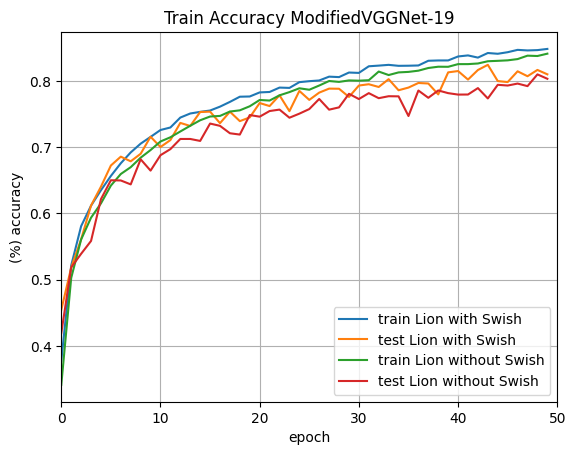

In [ ]:
plt.plot(results6['train_acc_list'], label="train Lion with Swish")
plt.plot(results6['test_acc_list'], label="test Lion with Swish")
plt.plot(results7['train_acc_list'], label="train Lion without Swish")
plt.plot(results7['test_acc_list'], label="test Lion without Swish")
plt.grid(True)
plt.xlim(0, 50)
plt.xlabel("epoch")
plt.ylabel("(%) accuracy")
plt.title("Train Accuracy ModifiedVGGNet-19")
plt.legend()
plt.show()

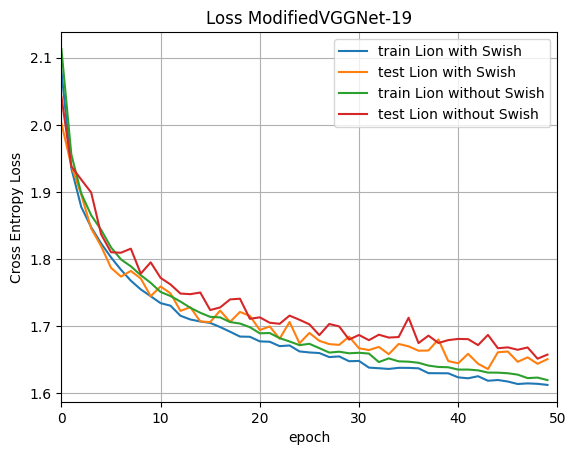

In [ ]:
plt.plot(results6['train_loss_list'], label="train Lion with Swish")
plt.plot(results6['test_loss_list'], label="test Lion with Swish")
plt.plot(results7['train_loss_list'], label="train Lion without Swish")
plt.plot(results7['test_loss_list'], label="test Lion without Swish")
plt.grid(True)
plt.xlim(0, 50)
plt.xlabel("epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss ModifiedVGGNet-19")
plt.legend()
plt.show()

#### Plot train result

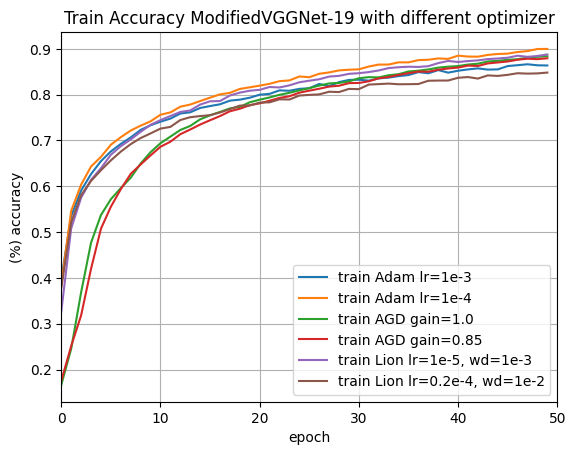

In [ ]:
plt.plot(results1['train_acc_list'], label="train Adam lr=1e-3")
plt.plot(results2['train_acc_list'], label="train Adam lr=1e-4")
plt.plot(results3['train_acc_list'], label="train AGD gain=1.0")
plt.plot(results4['train_acc_list'], label="train AGD gain=0.85")
plt.plot(results5['train_acc_list'], label="train Lion lr=1e-5, wd=1e-3")
plt.plot(results6['train_acc_list'], label="train Lion lr=0.2e-4, wd=1e-2")
plt.grid(True)
plt.xlim(0, 50)
plt.xlabel("epoch")
plt.ylabel("(%) accuracy")
plt.title("Train Accuracy ModifiedVGGNet-19 with different optimizer")
plt.legend()
plt.show()

#### Plot Testing Result

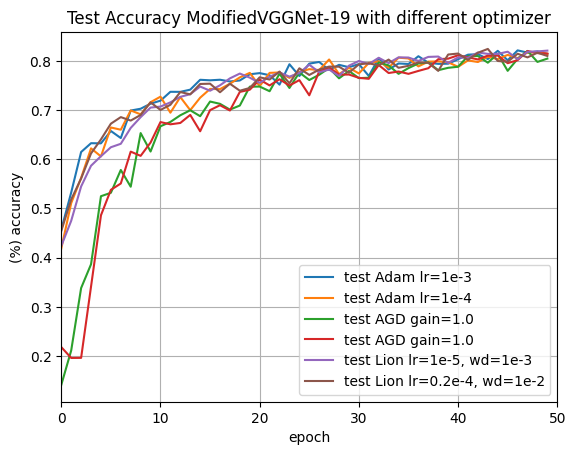

In [ ]:
plt.plot(results1['test_acc_list'], label="test Adam lr=1e-3")
plt.plot(results2['test_acc_list'], label="test Adam lr=1e-4")
plt.plot(results3['test_acc_list'], label="test AGD gain=1.0")
plt.plot(results4['test_acc_list'], label="test AGD gain=1.0")
plt.plot(results5['test_acc_list'], label="test Lion lr=1e-5, wd=1e-3")
plt.plot(results6['test_acc_list'], label="test Lion lr=0.2e-4, wd=1e-2")
plt.grid(True)
plt.xlim(0, 50)
plt.xlabel("epoch")
plt.ylabel("(%) accuracy")
plt.title("Test Accuracy ModifiedVGGNet-19 with different optimizer")
plt.legend()
plt.show()

#### Plot Train Loss

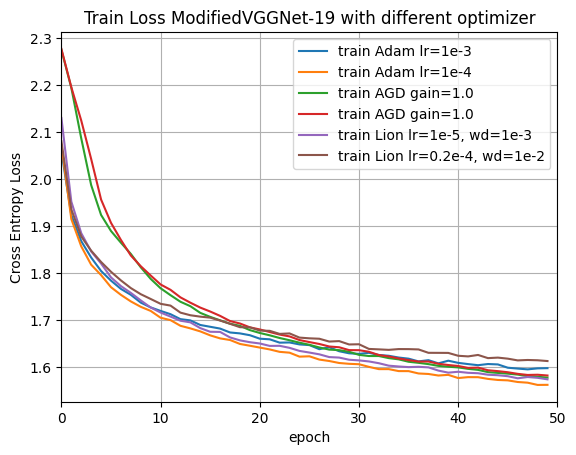

In [ ]:
plt.plot(results1['train_loss_list'], label="train Adam lr=1e-3")
plt.plot(results2['train_loss_list'], label="train Adam lr=1e-4")
plt.plot(results3['train_loss_list'], label="train AGD gain=1.0")
plt.plot(results4['train_loss_list'], label="train AGD gain=1.0")
plt.plot(results5['train_loss_list'], label="train Lion lr=1e-5, wd=1e-3")
plt.plot(results6['train_loss_list'], label="train Lion lr=0.2e-4, wd=1e-2")
plt.grid(True)
plt.xlim(0, 50)
plt.xlabel("epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Train Loss ModifiedVGGNet-19 with different optimizer")
plt.legend()
plt.show()

#### Plot Test Loss

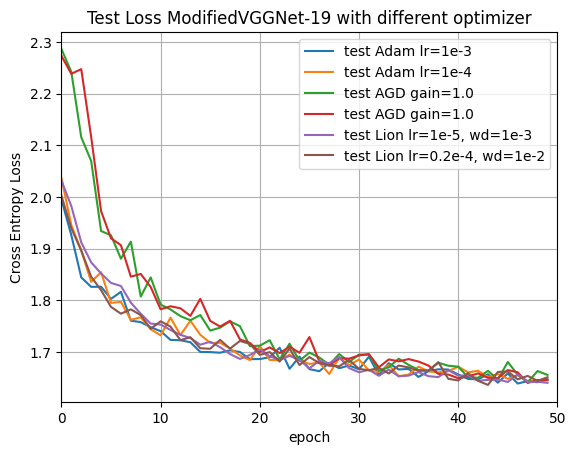

In [ ]:
plt.plot(results1['test_loss_list'], label="test Adam lr=1e-3")
plt.plot(results2['test_loss_list'], label="test Adam lr=1e-4")
plt.plot(results3['test_loss_list'], label="test AGD gain=1.0")
plt.plot(results4['test_loss_list'], label="test AGD gain=1.0")
plt.plot(results5['test_loss_list'], label="test Lion lr=1e-5, wd=1e-3")
plt.plot(results6['test_loss_list'], label="test Lion lr=0.2e-4, wd=1e-2")
plt.grid(True)
plt.xlim(0, 50)
plt.xlabel("epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Test Loss ModifiedVGGNet-19 with different optimizer")
plt.legend()
plt.show()

#### Checking output Manual (for 1 batch)

In [ ]:
import sys
torch.set_printoptions(threshold=sys.maxsize)
image, label = next(iter(test_loader))

#load agd model
model.load_state_dict(torch.load("Cifar_Lion.pth"))

output = model(image)
print(output.shape)
print(label.shape)
criterion = torch.nn.functional.cross_entropy(output, label)
print(criterion)

torch.Size([128, 10])
torch.Size([128])
tensor(1.6191, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
print("Predict from Model : \n",torch.argmax(output, axis=1))
print("Ground Truth : \n",label)

Predict from Model : 
 tensor([3, 1, 8, 8, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 2, 4, 0, 9, 6, 6, 5, 2, 5, 9, 8, 7, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 7, 3, 8, 8, 7, 3, 3, 6, 7, 5, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 9, 2, 9, 3, 3, 8, 8, 1, 1, 7, 3, 7, 7, 3, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 6, 6, 8, 7, 4, 0, 6, 2, 9, 9, 0, 4, 6, 7,
        8, 3, 1, 2, 8, 2, 8, 3], device='cuda:0')
Ground Truth : 
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
